# **TUGAS BESAR ANALISIS BIG DATA**

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofmonth, hour, minute, second, substring, mean, count, when, isnan
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName("Handling Missing Values and Regression").getOrCreate()

In [ ]:
# Baca data dari Google Drive
data = spark.read.csv("/content/drive/MyDrive/Data/Data_ABD_2.csv", header=True, inferSchema=True)

In [ ]:
# Mengonversi kolom menjadi tipe numerik
data = data.withColumn("Temperature C", col("Temperature C").cast("double"))
data = data.withColumn("Humidity %", col("Humidity %").cast("double"))

In [ ]:
# Menampilkan 5 baris teratas
data.show()

+--------------------+-------------+----------+
|                Time|Temperature C|Humidity %|
+--------------------+-------------+----------+
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|      90.7|
|2024-05-23 00:00:...|         28.9|    

In [ ]:
# Menampilkan schema DataFrame
data.printSchema()

root
 |-- Time: timestamp (nullable = true)
 |-- Temperature C: double (nullable = true)
 |-- Humidity %: double (nullable = true)



In [ ]:
# Menghitung jumlah baris dalam DataFrame
total_rows = data.count()

# Menampilkan jumlah baris
print(f"Jumlah baris dalam DataFrame: {total_rows}")

Jumlah baris dalam DataFrame: 1000003


In [ ]:
# Menampilkan Missing Value
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+-------------+----------+
|Time|Temperature C|Humidity %|
+----+-------------+----------+
|   0|            1|         3|
+----+-------------+----------+



In [ ]:
# Menghapus baris dengan missing value dan nilai NaN
data_clean = data.dropna()
data_clean = data_clean.filter(~isnan(col("Temperature C")) & ~isnan(col("Humidity %")))

In [ ]:
# Menampilkan kembali jumlah missing values setelah penghapusan
data_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in data_clean.columns]).show()

+----+-------------+----------+
|Time|Temperature C|Humidity %|
+----+-------------+----------+
|   0|            0|         0|
+----+-------------+----------+



In [ ]:
# Menampilkan Statistik Deskriptif Sebelum Pembersihan
print("Statistik Deskriptif Sebelum Pembersihan:")
data_clean.describe().show()

Statistik Deskriptif Sebelum Pembersihan:
+-------+------------------+-----------------+
|summary|     Temperature C|       Humidity %|
+-------+------------------+-----------------+
|  count|            999259|           999259|
|   mean|30.751386977776548|81.64017346852884|
| stddev|  5.60171753490026|19.72944437742941|
|    min|              -1.6|             47.1|
|    max|            3333.9|           9229.5|
+-------+------------------+-----------------+



In [ ]:
# Fungsi untuk mengidentifikasi outlier menggunakan IQR
def identify_outliers(df, column):
    q1 = df.approxQuantile(column, [0.25], 0.05)[0]
    q3 = df.approxQuantile(column, [0.75], 0.05)[0]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

lower_temp, upper_temp = identify_outliers(data_clean, 'Temperature C')
lower_hum, upper_hum = identify_outliers(data_clean, 'Humidity %')

print(f"Temperature C outliers are outside the range {lower_temp} to {upper_temp}")
print(f"Humidity % outliers are outside the range {lower_hum} to {upper_hum}")

Temperature C outliers are outside the range 19.800000000000004 to 42.199999999999996
Humidity % outliers are outside the range 40.00000000000001 to 123.19999999999999


In [ ]:
# Menghapus outlier
data_clean = data_clean.filter((col('Temperature C') >= lower_temp) & (col('Temperature C') <= upper_temp) &
                               (col('Humidity %') >= lower_hum) & (col('Humidity %') <= upper_hum))

In [ ]:
# Menampilkan Statistik Deskriptif Setelah Menghapus Outlier
print("Statistik Deskriptif Setelah Menghapus Outlier:")
data_clean.describe().show()

Statistik Deskriptif Setelah Menghapus Outlier:
+-------+------------------+------------------+
|summary|     Temperature C|        Humidity %|
+-------+------------------+------------------+
|  count|            999230|            999230|
|   mean|30.744787086081953| 81.62200964741741|
| stddev| 3.431266640750904|14.952236143781398|
|    min|              26.1|              47.1|
|    max|              41.6|             100.8|
+-------+------------------+------------------+



In [ ]:
# Mengubah kolom waktu menjadi format datetime
data_clean = data_clean.withColumn('Time', col('Time').cast('timestamp'))

In [ ]:
# Ekstraksi fitur tambahan dari kolom waktu
data_clean = data_clean.withColumn('jam', hour(col('Time')))
data_clean = data_clean.withColumn('menit', minute(col('Time')))
data_clean = data_clean.withColumn('detik', second(col('Time')))
data_clean = data_clean.withColumn('milidetik', substring(col('Time').cast('string'), 20, 3).cast('int'))

In [ ]:
# Memastikan tidak ada nilai null di kolom fitur
data_clean = data_clean.na.drop(subset=['jam', 'menit', 'detik', 'milidetik', 'Humidity %'])

In [ ]:
# Memilih fitur dan label
feature_cols = ['jam', 'menit', 'detik', 'milidetik', 'Humidity %']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_clean = assembler.transform(data_clean)

In [ ]:
# Memilih label
data_clean = data_clean.withColumnRenamed('Temperature C', 'label')

In [ ]:
# Pembagian data menjadi set pelatihan dan pengujian
train_data, test_data = data_clean.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Skalasi fitur jika diperlukan
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_data)
train_data = scaler_model.transform(train_data)
test_data = scaler_model.transform(test_data)

In [ ]:
# Inisialisasi dan latih model regresi linear
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='label')
lr_model = lr.fit(train_data)

In [ ]:
# Prediksi dan evaluasi
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1.4967547186490675
R-squared: 0.8725234806759763


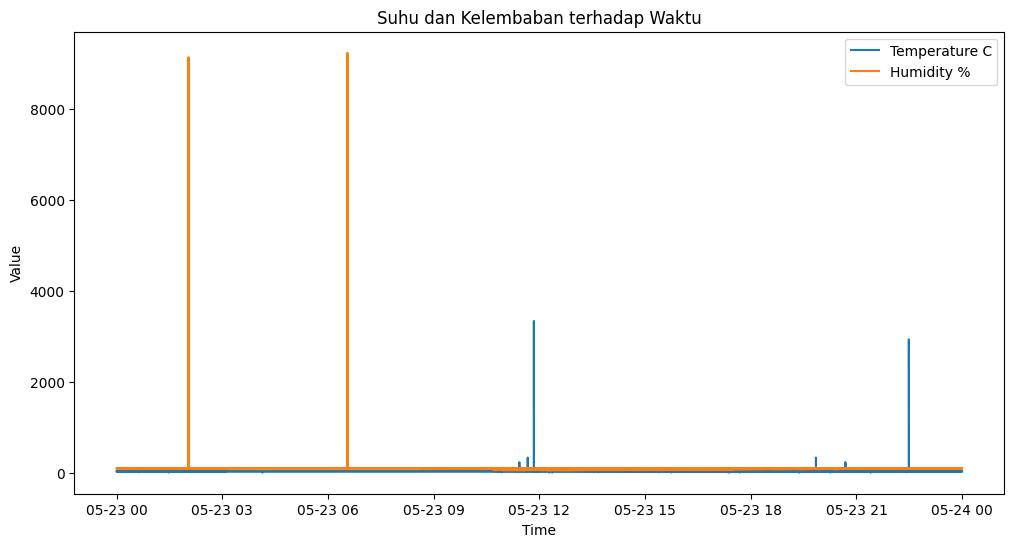

In [ ]:
# Visualisasi Data Sebelum Dibersihkan
data_pd = data.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(data_pd['Time'], data_pd['Temperature C'], label='Temperature C')
plt.plot(data_pd['Time'], data_pd['Humidity %'], label='Humidity %')
plt.title('Suhu dan Kelembaban terhadap Waktu')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

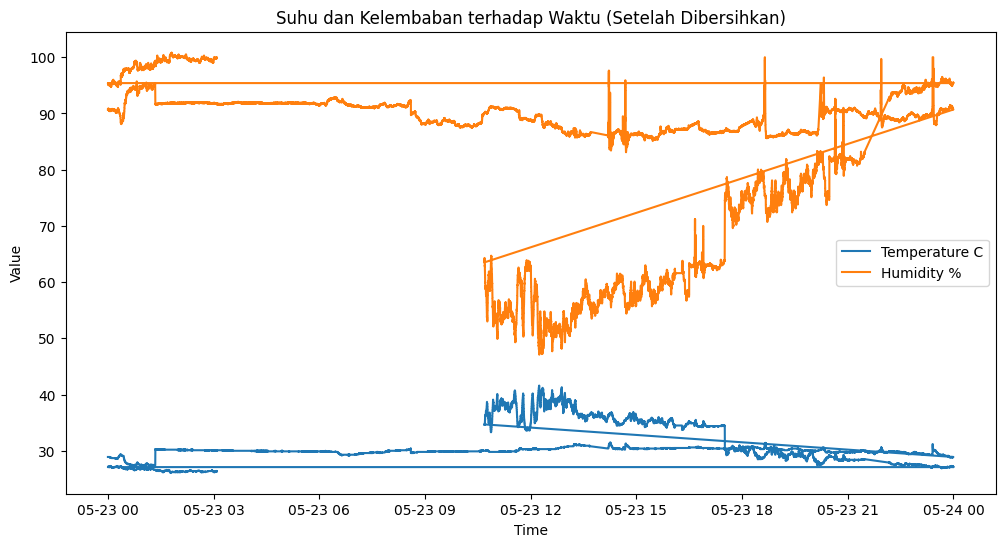

In [ ]:
# Visualisasi Data Setelah Dibersihkan
plt.figure(figsize=(12, 6))
plt.plot(data_clean_pd['Time'], data_clean_pd['label'], label='Temperature C')
plt.plot(data_clean_pd['Time'], data_clean_pd['Humidity %'], label='Humidity %')
plt.title('Suhu dan Kelembaban terhadap Waktu (Setelah Dibersihkan)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

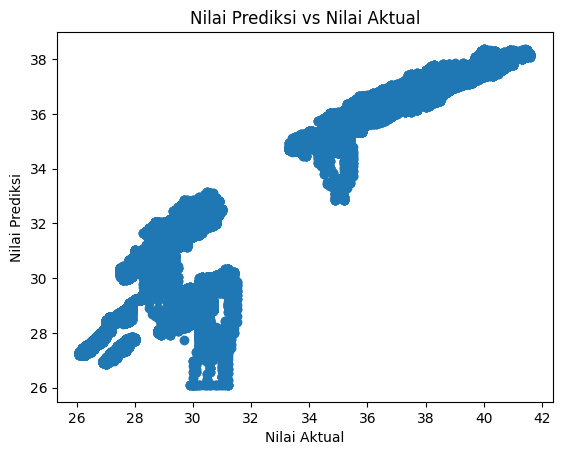

In [ ]:
# Plot Hasil Prediksi vs Nilai Aktual
predictions_pd = predictions.select("prediction", "label").toPandas()
plt.scatter(predictions_pd['label'], predictions_pd['prediction'])
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.title('Nilai Prediksi vs Nilai Aktual')
plt.show()

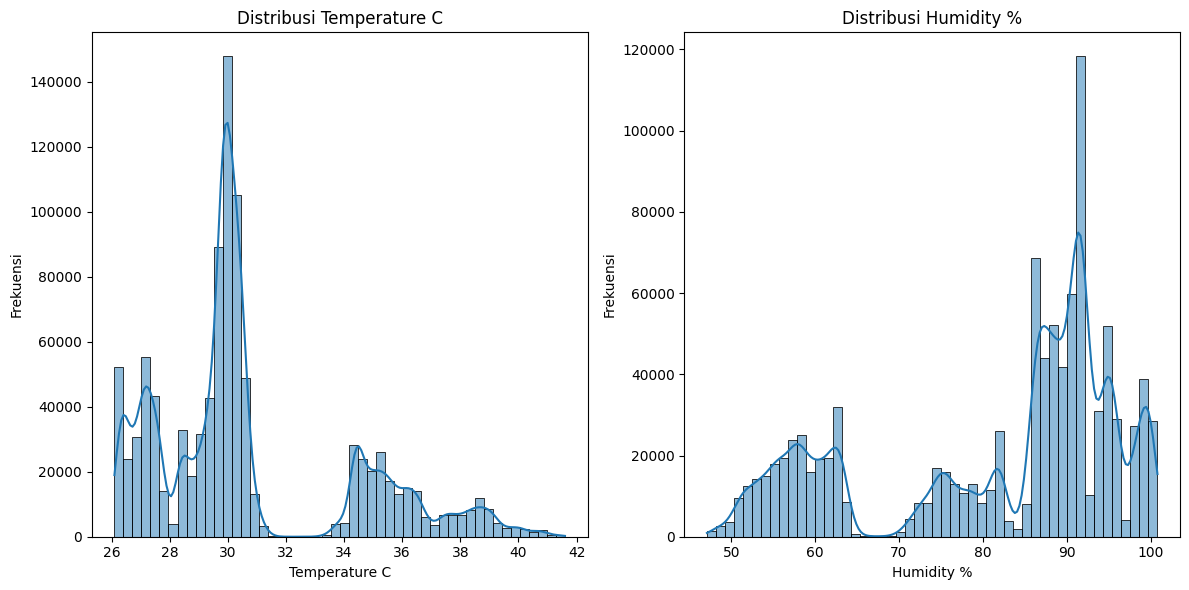

In [ ]:
# Plot Histogram untuk Suhu dan Kelembaban
data_clean_pd = data_clean.toPandas()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_clean_pd['label'], bins=50, kde=True)
plt.title('Distribusi Temperature C')
plt.xlabel('Temperature C')
plt.ylabel('Frekuensi')

plt.subplot(1, 2, 2)
sns.histplot(data_clean_pd['Humidity %'], bins=50, kde=True)
plt.title('Distribusi Humidity %')
plt.xlabel('Humidity %')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()


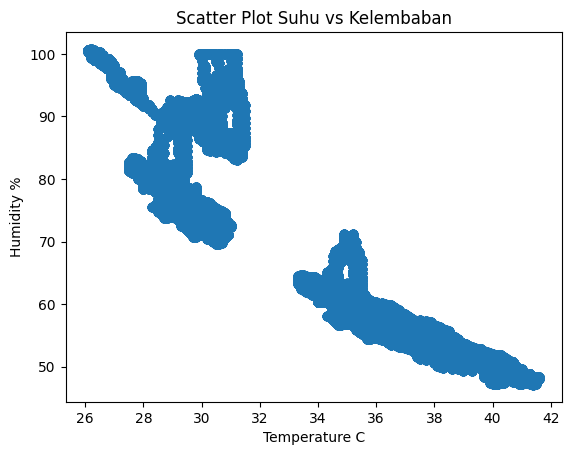

In [ ]:
# Plot Scatter Plot Suhu vs Kelembaban
plt.scatter(data_clean_pd['label'], data_clean_pd['Humidity %'])
plt.xlabel('Temperature C')
plt.ylabel('Humidity %')
plt.title('Scatter Plot Suhu vs Kelembaban')
plt.show()

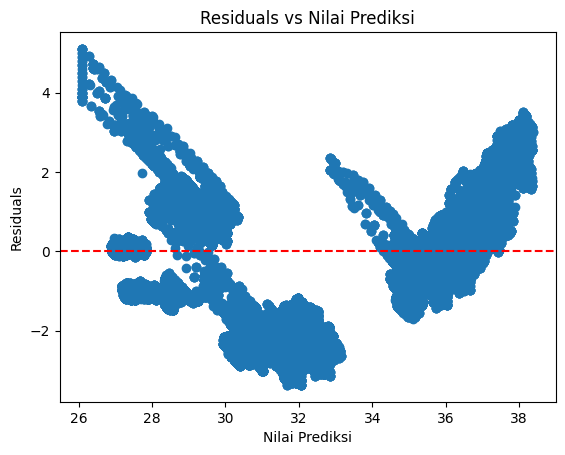

In [ ]:
# Plot Residuals
residuals = predictions_pd['label'] - predictions_pd['prediction']
plt.scatter(predictions_pd['prediction'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residuals')
plt.title('Residuals vs Nilai Prediksi')
plt.show()

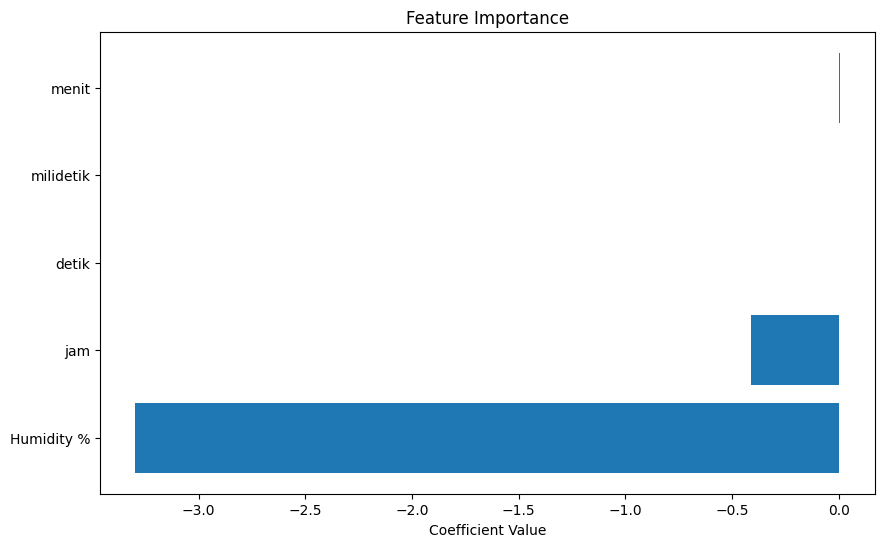

In [ ]:
# Plot Feature Importance
importance = lr_model.coefficients.toArray()
features = feature_cols
indices = np.argsort(importance)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importance[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Coefficient Value')
plt.show()